In [5]:
import numpy as np
from sklearn.linear_model import Ridge
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd

/home/maria/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

In [8]:
data_path= '/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files/Richards_2017-10-31.tar'
good_cells, brain_regions,br = get_good_cells(data_path)

In [ ]:
#Cub-circuits of interest
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

In [9]:
dat=np.load('trial_av_dat.npy')

In [10]:
mos=dat[brain_regions=='MOs']
print(mos.shape)
scs=dat[brain_regions=='SCs']

(122, 75)


In [41]:
from sklearn.model_selection import train_test_split

front_train, front_test, mid_train,mid_test=train_test_split(mos.T,scs.T, test_size=0.33, random_state=42)

In [70]:
from sklearn.decomposition import PCA
pca_mid=PCA(n_components=5)
pca_frontal=PCA(n_components=10)
pcs_mid=pca_mid.fit_transform(mid_train)
print(pcs_mid.shape)
pcs_front=pca_frontal.fit_transform(front_train)
print(pca_mid.explained_variance_)
print(pca_frontal.explained_variance_)
print(np.cumsum(pca_mid.explained_variance_))
print(np.cumsum(pca_frontal.explained_variance_))

(50, 5)
[0.02589523 0.00681757 0.00532994 0.00392899 0.00303052]
[0.2255974  0.04749687 0.0053819  0.00257394 0.00129414 0.00120877
 0.00093061 0.00089674 0.00076753 0.00070504]
[0.02589523 0.0327128  0.03804275 0.04197174 0.04500226]
[0.2255974  0.27309427 0.27847617 0.28105011 0.28234425 0.28355302
 0.28448362 0.28538037 0.2861479  0.28685294]


In [43]:
print(pcs_front.shape)
print(pcs_mid.shape)

(50, 10)
(50, 10)


In [71]:
from sklearn.linear_model import Ridge

mod=Ridge()

mod.fit(pcs_front,pcs_mid)
print()
#mod.score(X_test,y_test)
pr=mod.predict(pca_frontal.transform(front_test))
print(pr.shape)
#print(y_test.shape)
pcs_corr=[]
for j in range(0,5):
    print(np.corrcoef(pr[:,j],mid_test[:,j])[0,1])
    pcs_corr.append(np.corrcoef(pr[:,j],mid_test[:,j])[0,1])


(25, 5)
-0.03167029761738858
-0.37427187141339624
-0.24293908520088495
-0.30899075231374223
0.25437290036550314


(array([1., 1., 1., 0., 0., 1., 0., 0., 0., 1.]),
 array([-0.37427187, -0.31140739, -0.24854292, -0.18567844, -0.12281396,
        -0.05994949,  0.00291499,  0.06577947,  0.12864395,  0.19150842,
         0.2543729 ]),
 <a list of 10 Patch objects>)

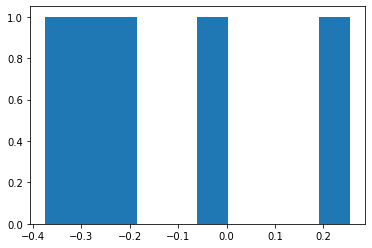

In [72]:
plt.hist(pcs_corr)

In [98]:
mod.coef_.shape
print(front_test.shape)
pca_frontal.transform(front_test).shape
print(pca_mid.transform(mid_test).shape)

(25, 122)
(25, 5)


In [97]:
predictions=[]
for pc in range(0,5):
    prediction=mod.coef_@pca_frontal.transform(front_test).T
    print(prediction.shape)

(5, 25)
(5, 25)
(5, 25)
(5, 25)
(5, 25)


In [112]:
def variance_explained(dat_mat,prediction_mat):
    residuals=(dat_mat-prediction_mat.T)**2
    print(residuals.shape)
    natural_variance=(dat_mat-np.mean(dat_mat,axis=0))**2
    print(natural_variance.shape)
    return 1-residuals.sum()/natural_variance.sum()

In [113]:
variance_explained(pca_mid.transform(mid_test),prediction)

(25, 5)
(25, 5)


0.546605197777607

In [122]:
pca_mid.transform(mid_test).shape
#pca_frontal.transform(front_test).shape
mod.score(pca_frontal.transform(front_test),pca_mid.transform(mid_test))

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5466051977776063